In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
movies_TFIDF = pd.read_csv('3a movies_TFIDF.csv')
movies_embedded = pd.read_csv('3b movies_Embedded.csv')
country_codes = pd.read_csv('country_codes.csv')

In [7]:
## Drop the remaining NaN values
# movies_TFIDF.dropna(inplace = True)
# movies_TFIDF.to_csv('3a movies_TFIDF.csv', index=False)
# movies_embedded.dropna(inplace = True)
# movies_embedded.to_csv('3b movies_Embedded.csv', index=False)

In [3]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    # Convert these to arrays

    movies['genres'] = movies['genres'].apply(lambda str: get_numbers(str))
    movies['production_companies'] = movies['production_companies'].apply(lambda str: get_numbers(str))
    movies['production_countries'] = movies['production_countries'].apply(lambda str: get_country_codes(str)) # This takes time
    
    # Get dummies
    mlb = MultiLabelBinarizer()
    genres = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_companies = pd.DataFrame(mlb.fit_transform(movies['production_companies']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_countries = pd.DataFrame(mlb.fit_transform(movies['production_countries']), columns=mlb.classes)

    original_language = pd.get_dummies(movies['original_language'])
    
    # Rename the columns to unique names
    for i in range(genres.shape[1]):
        genres.rename(mapper={i : str(i) + '. genre'}, axis=1, inplace=True)
    
    for i in range(production_countries.shape[1]):
        production_countries.rename(mapper={i : str(i) + '. country'}, axis=1, inplace=True)
        
    # production_companies is not used in this version
    movievectors = movies.drop(['genres', 'production_companies', 'production_countries', 'original_language', 'id', 'title'], axis=1).join(
        genres).join(production_countries).join(original_language)
    
    # Scale the values to (0, 1) interval
    scaler = MinMaxScaler()
    scaler.fit_transform(movievectors)
    
    return movievectors

In [4]:
movies_TFIDF = prepare_dataframe(movies_TFIDF)
movies_embedded = prepare_dataframe(movies_embedded)

Use silhouette score for test purposes:

In [5]:
# 1. test: TF-IDF vs Embedded Layers
df1 = pd.DataFrame(columns=['Number of clusters', 'TF-IDF', 'Embedded Layers'])
for i in range(5, 51, 5):
    
    # Kmeans
    kmeans_TFIDF = KMeans(n_clusters=i)
    kmeans_TFIDF.fit(movies_TFIDF)
    
    kmeans_embedded = KMeans(n_clusters=i)
    kmeans_embedded.fit(movies_embedded)
    
    tfscore = silhouette_score(movies_TFIDF, kmeans_TFIDF.predict(movies_TFIDF))
    emscore = silhouette_score(movies_embedded, kmeans_embedded.predict(movies_embedded))
    scores = pd.DataFrame([[i, tfscore, emscore]], columns=['Number of clusters', 'TF-IDF', 'Embedded Layers'])
    df1 = pd.concat([df1, scores], axis=0)

In [22]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of clusters', ylabel='Silhouette Score'>

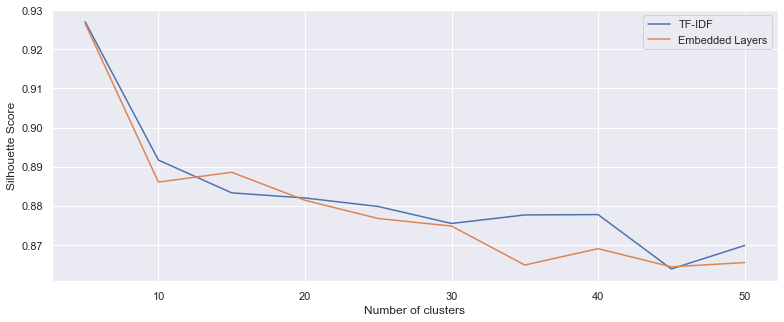

In [53]:
# Visualize the results
sns.set_theme(style="darkgrid")
plt.figure(figsize=(13,5))
plt.ylabel('Silhouette Score')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF', label='TF-IDF')
sns.lineplot(data = df1, x='Number of clusters', y='Embedded Layers', label='Embedded Layers')

# Just some of my thoughts about the result in hungarian:
# Egy másik általam futtatott teszten - ugyanilyen feltételekkel - már az Embedded Layers teljesített jobban
# Ez valószínűleg amiatt volt, hogy a klaszterek mindig véletlenszerű kezdőpontból indulnak, ezért mindig "kicsit" másabbak
# A kettő közti különbség ezért nem egyértelmű, ennyi adat/kisérlet alapján nem eldönthető melyik a jobb.

In [24]:
# 2. test: Time test on TF-IDF
df2 = pd.DataFrame(columns=['Number of clusters', 'Silhouette Score', 'Runtime'])
for i in range(5, 51, 5):
    
    start = time.time()
    
    # Kmeans
    kmeans_TFIDF = KMeans(n_clusters=i)
    kmeans_TFIDF.fit(movies_TFIDF)
    
    # Runtime is in seconds
    end = time.time()
    
    tfscore = silhouette_score(movies_TFIDF, kmeans_TFIDF.predict(movies_TFIDF))
    tftime = end - start
    
    scores = pd.DataFrame([[i, tfscore, tftime]], columns=['Number of clusters', 'Silhouette Score', 'Runtime'])
    df2 = pd.concat([df2, scores], axis=0)

In [25]:
df2 = df2.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of clusters', ylabel='Runtime in seconds'>

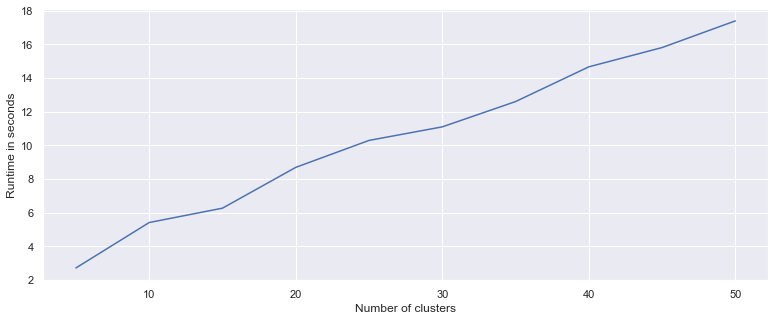

In [59]:
# Visualize the results
sns.set_theme(style="darkgrid")
plt.figure(figsize=(13,5))
plt.ylabel('Runtime in seconds')

sns.lineplot(data = df2, x='Number of clusters', y='Runtime')
sns.lineplot()

In [ ]:
# 3. test: PCA on TF-IDF 50 clusters
# NOT FINISHED YET!
df3 = pd.DataFrame(columns=['Number of features', 'Silhouette Score', 'Runtime'])
for i in range(5, 11, 5):
    
    start = time.time()
    
    # Kmeans
    kmeans_TFIDF = KMeans(n_clusters=i)
    kmeans_TFIDF.fit(movies_TFIDF)
    
    # Runtime is in seconds
    end = time.time()
    
    tfscore = silhouette_score(movies_TFIDF, kmeans_TFIDF.predict(movies_TFIDF))
    tftime = end - start
    
    scores = pd.DataFrame([[i, tfscore, tftime]], columns=['Number of clusters', 'Silhouette Score', 'Runtime'])
    df2 = pd.concat([df2, scores], axis=0)